<a href="https://colab.research.google.com/github/miczkejedrzej/MNLP-project-1/blob/main/Data_collection_Country_P17_P27_P495.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import of the training data

from google.colab import files
uploaded = files.upload()

# Import of moduls

!pip install wikidata --quiet

import matplotlib.pyplot as plt
import pandas as pd
from wikidata.client import Client

from tqdm.auto import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Loading the data
train_df = pd.read_csv('[MNLP 2025 HW1] train set [PUBLIC] - train_cleaned.tsv', sep='\t')

Saving [MNLP 2025 HW1] train set [PUBLIC] - train_cleaned.tsv to [MNLP 2025 HW1] train set [PUBLIC] - train_cleaned.tsv


# Training dataset

In [ ]:
train_df = pd.read_csv('[MNLP 2025 HW1] train set [PUBLIC] - train_cleaned.tsv', sep='\t')

In [2]:
def extract_entity_id(url):
    return url.strip().split("/")[-1]

In [3]:
def get_claims(wikidata_url):
  # Extract the id of the item
    entity_id = extract_entity_id(wikidata_url)

    # Extract information of the item
    client = Client()
    item = client.get(entity_id, load=True)

    # Extract the claims of the item
    claims = item.data.get("claims", {})

    return claims

In [4]:
def get_country(wikidata_url):

    claims = get_claims(wikidata_url)
    client = Client()

    country_of_origin_id = None
    country_id = None
    nationality_id = None

    # Extract the statement "P495" : Country of origin
    unicode_statements = claims.get("P495", [])
    if unicode_statements:
        for statement in unicode_statements:
            mainsnak = statement.get("mainsnak", {})
            datavalue = mainsnak.get("datavalue", {})
            value = datavalue.get("value", {})

            country_of_origin_id = value.get("id")

            return country_of_origin_id, None, None


    # Extract the statement "P17" : Country
    unicode_statements = claims.get("P17", [])
    if unicode_statements:
        for statement in unicode_statements:
            mainsnak = statement.get("mainsnak", {})
            datavalue = mainsnak.get("datavalue", {})
            value = datavalue.get("value", {})
            country_id = value.get("id")

            return None, country_id, None


    # Extract the statement "P27" : Nationality
    unicode_statements = claims.get("P27", [])
    if unicode_statements:
        for statement in unicode_statements:
            mainsnak = statement.get("mainsnak", {})
            datavalue = mainsnak.get("datavalue", {})
            value = datavalue.get("value", {})
            nationality_id = value.get("id")

            return None, None, nationality_id

    return country_of_origin_id, country_id, nationality_id


# Test on one line of the DataFrame
#wikidata_url = train_df.iloc[532, 0]
#get_country(wikidata_url)

In [5]:
# Due to some errors when we apply get_country to the dataframe, we create a more safety function

def safe_get_country(wikidata_url):
    try:
        return get_country(wikidata_url)
    except:
        return None, None, None

In [6]:
# We merge the variables, in order to have only one.

def merge_variables(df, variables):
  """
  Take in input, the variables of a dataframe, and return a dataframe with a single variable => the first value founded across the rows
  """
  return df[variables].bfill(axis=1).iloc[:, 0]

In [ ]:
# Application to the whole dataset
train_df[['country_of_origin', 'country', 'nationality']] = train_df['item'].apply(lambda url: pd.Series(safe_get_country(url)))

In [ ]:
train_df

,item,name,description,type,category,subcategory,label,country_of_origin,country,nationality
0,http://www.wikidata.org/entity/Q306,Sebastián Piñera,Chilean entrepreneur and politician (1949–2024),entity,politics,politician,cultural exclusive,None,None,Q298
1,http://www.wikidata.org/entity/Q12735,John Amos Comenius,"Czech teacher, educator, philosopher and write...",entity,politics,politician,cultural representative,None,None,Q153136
2,http://www.wikidata.org/entity/Q1752,Macrinus,Roman emperor from 217 to 218,entity,politics,politician,cultural representative,None,None,Q1747689
3,http://www.wikidata.org/entity/Q1639,Lamine Diack,Senegalese sports manager (1933–2021),entity,politics,politician,cultural representative,None,None,Q1041
4,http://www.wikidata.org/entity/Q9588,Richard Nixon,President of the United States from 1969 to 1974,entity,politics,politician,cultural representative,None,None,Q30
...,...,...,...,...,...,...,...,...,...,...
6246,http://www.wikidata.org/entity/Q321103,Bühl,"quarter of Tübingen, Baden-Württemberg, Germany",entity,geography,neighborhood,cultural exclusive,None,Q183,None
6247,http://www.wikidata.org/entity/Q338167,Tenderloin,area of New York City during the late 19th and...,entity,geography,neighborhood,cultural exclusive,None,Q30,None
6248,http://www.wikidata.org/entity/Q66991,Schinznach-Dorf,former municipality and current district of Sc...,entity,geography,neighborhood,cultural exclusive,None,Q39,None
6249,http://www.wikidata.org/entity/Q66922,Ependes,village and former municipality in Bois-d'Amon...,entity,geography,neighborhood,cultural exclusive,None,Q39,None


In [ ]:
# Merge the 3 features
train_df['main_country'] = merge_variables(train_df, ['country_of_origin', 'country', 'nationality'])

# Delete the 3 other features
train_df.drop(['country_of_origin', 'country', 'nationality'], axis=1, inplace=True)

In [ ]:
# Visualisation
train_df

,item,name,description,type,category,subcategory,label,main_country
0,http://www.wikidata.org/entity/Q306,Sebastián Piñera,Chilean entrepreneur and politician (1949–2024),entity,politics,politician,cultural exclusive,Q298
1,http://www.wikidata.org/entity/Q12735,John Amos Comenius,"Czech teacher, educator, philosopher and write...",entity,politics,politician,cultural representative,Q153136
2,http://www.wikidata.org/entity/Q1752,Macrinus,Roman emperor from 217 to 218,entity,politics,politician,cultural representative,Q1747689
3,http://www.wikidata.org/entity/Q1639,Lamine Diack,Senegalese sports manager (1933–2021),entity,politics,politician,cultural representative,Q1041
4,http://www.wikidata.org/entity/Q9588,Richard Nixon,President of the United States from 1969 to 1974,entity,politics,politician,cultural representative,Q30
...,...,...,...,...,...,...,...,...
6246,http://www.wikidata.org/entity/Q321103,Bühl,"quarter of Tübingen, Baden-Württemberg, Germany",entity,geography,neighborhood,cultural exclusive,Q183
6247,http://www.wikidata.org/entity/Q338167,Tenderloin,area of New York City during the late 19th and...,entity,geography,neighborhood,cultural exclusive,Q30
6248,http://www.wikidata.org/entity/Q66991,Schinznach-Dorf,former municipality and current district of Sc...,entity,geography,neighborhood,cultural exclusive,Q39
6249,http://www.wikidata.org/entity/Q66922,Ependes,village and former municipality in Bois-d'Amon...,entity,geography,neighborhood,cultural exclusive,Q39


In [ ]:
# Exportation

train_df.to_json("train_df_country.json", orient="records", lines=True)
files.download('train_df_country.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Dev dataset

In [7]:
# Import of the training data

!pip install datasets --quiet

from datasets import load_dataset
from huggingface_hub import login

# First : Create an account on Hugging face, and create also a token

# Connection to hugging face
login(token="")

dataset = load_dataset('sapienzanlp/nlp2025_hw1_cultural_dataset')
dev_df = dataset['validation'].to_pandas()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cu

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.31k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/946k [00:00<?, ?B/s]

valid.csv:   0%|          | 0.00/45.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6251 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/300 [00:00<?, ? examples/s]

In [8]:
# Application to the whole dataset
dev_df[['country_of_origin', 'country', 'nationality']] = dev_df['item'].apply(lambda url: pd.Series(safe_get_country(url)))

In [9]:
# Merge the 3 features
dev_df['main_country'] = merge_variables(dev_df, ['country_of_origin', 'country', 'nationality'])

# Delete the 3 other features
dev_df.drop(['country_of_origin', 'country', 'nationality'], axis=1, inplace=True)

In [10]:
# Visualisation
dev_df

,item,name,description,type,category,subcategory,label,main_country
0,http://www.wikidata.org/entity/Q15786,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",entity,sports,sports club,cultural representative,Q183
1,http://www.wikidata.org/entity/Q268530,77 Records,UK record label,entity,music,record label,cultural exclusive,Q145
2,http://www.wikidata.org/entity/Q216153,A Bug's Life,1998 animated film directed by John Lasseter a...,entity,comics and anime,animated film,cultural representative,Q30
3,http://www.wikidata.org/entity/Q593,A Gang Story,2011 film by Olivier Marchal,entity,films,film,cultural exclusive,Q142
4,http://www.wikidata.org/entity/Q192185,Aaron Copland,"American composer, composition teacher, writer...",entity,performing arts,choreographer,cultural representative,Q30
...,...,...,...,...,...,...,...,...
295,http://www.wikidata.org/entity/Q36180,writer,person who uses written words to communicate i...,concept,visual arts,artist,cultural agnostic,None
296,http://www.wikidata.org/entity/Q156316,Würzburg Residence,cultural heritage monument D-6-63-000-454 (0) ...,entity,history,museum,cultural representative,Q183
297,http://www.wikidata.org/entity/Q56911,xunfu,high government official of the Chinese Ming a...,concept,politics,politician,cultural exclusive,Q9903
298,http://www.wikidata.org/entity/Q377,Yanka Kupala,Belarusian writer (1882–1942),entity,literature,poet,cultural representative,Q34266


In [11]:
# Exportation

dev_df.to_json("dev_df_country.json", orient="records", lines=True)
files.download('dev_df_country.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Plots : Should we put it in another notebook ?

Once we will have collected all the variables, and create a single dataframe, we could create a notebook that, regarding the new dataframe, with all the features, could present all the plots ?

In [ ]:
# Apply the function to a subset of the DataFrame
def add_country_information(df,lower_bound=10,upper_bound=100,category =None):

  df = df.sample(frac=1).reset_index(drop=True)
  subset = range(lower_bound,upper_bound)

  if category is not None:
    df = df[(df['label'] == category)]
    #df = df[(df['label'] == 'cultural exclusive')]
    df.reset_index(drop=True, inplace=True)

  country_informations = df.loc[subset, "item"].apply(lambda url: get_country(url))

  variables = ['country_of_origin_id', 'country_id', 'nationality_id']
  country_informations_df = pd.DataFrame(country_informations.tolist(), columns=variables)


  # We merge the variables, in order to have only one
  country_informations_df['country'] = merge_variables(country_informations_df, variables)
  country_informations_df.drop(variables, axis=1, inplace=True)

  # We add the new variable to the training dataset
  df.loc[subset, 'country'] = country_informations_df['country'].values


  df.iloc[lower_bound:upper_bound, df.columns.get_loc('country')] = country_informations_df['country'].values


  return df

  0%|          | 0/3 [00:00<?, ?it/s]

 the ratio of the entries with the country information to all entries 
 in randomaly choosen sample of 200 records with labels: cultural exclusive is 0.15


 the ratio of the entries with the country information to all entries 
 in randomaly choosen sample of 200 records with labels: cultural representative is 0.34


 the ratio of the entries with the country information to all entries 
 in randomaly choosen sample of 200 records with labels: cultural agnostic is 0.9




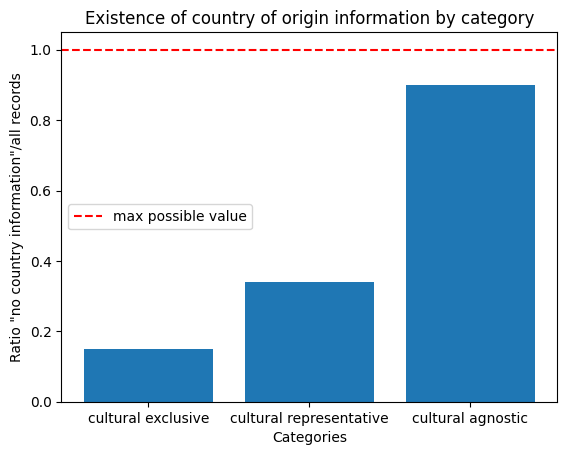

In [ ]:
#
lower_bound = 0
upper_bound = 200
subset = range(lower_bound,upper_bound)
total = upper_bound - lower_bound
nan_counts = []
categories = ['cultural exclusive', 'cultural representative', 'cultural agnostic']
for i in tqdm(range(len(categories))):
  enriched_train_df = add_country_information(train_df,lower_bound,upper_bound,categories[i])
  nan_ratio = enriched_train_df.loc[subset,'country'].isna().sum()/total
  nan_counts.append(nan_ratio)


for i in range(len(categories)):
    print(f' the ratio of the entries with the country information to all entries \n in randomaly choosen sample of {upper_bound-lower_bound} records with labels: {categories[i]} is {nan_counts[i]}')
    print('\n')


# Total rows in the subset

import matplotlib.pyplot as plt

# Sample data

# Create bar chart
plt.bar(categories, nan_counts)
plt.title('Existence of country of origin information by category')
plt.xlabel('Categories')
plt.ylabel('Ratio "no country information"/all records')
plt.axline((0, 1), slope=0, color='red', linestyle='--',label = 'max possible value')
plt.legend()
plt.show()


